In [8]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from tabulate import tabulate

from sklearn.metrics import accuracy_score, f1_score, brier_score_loss

from models import rain_nn, calibrate_rain_nn
from calibration import expected_calibration_error, max_calibration_error, overconfidence_error, inverse_probability_weighting

sns.set(rc={'figure.figsize':(15,5)})

Read validation and test dataset

In [9]:
# read the validation data
validation_df = pd.read_csv("datasets/cleaned_weatherAUS_validation.csv")
X_validation = validation_df.drop(["RainTomorrow"], axis=1)
y_validation = validation_df["RainTomorrow"]

# read the test data
test_df = pd.read_csv("datasets/cleaned_weatherAUS_test.csv")
X_test = test_df.drop(["RainTomorrow"], axis=1)
y_test = test_df["RainTomorrow"]

Create neural network models

In [10]:
# create a dictionary of models
rain_nn = rain_nn()
rain_nn_ps = calibrate_rain_nn(rain_nn, "ps")
rain_nn_ops = calibrate_rain_nn(rain_nn, "ops")
rain_nn_ir = calibrate_rain_nn(rain_nn, "ir")
models = {"nn": rain_nn, "nn_ps": rain_nn_ps, "nn_ops": rain_nn_ops, "nn_ir": rain_nn_ir}

Iteration 1, loss = 0.66501205
Iteration 2, loss = 0.57892355
Iteration 3, loss = 0.51988955
Iteration 4, loss = 0.47540473
Iteration 5, loss = 0.44171869
Iteration 6, loss = 0.41644872
Iteration 7, loss = 0.39792171
Iteration 8, loss = 0.38436921
Iteration 9, loss = 0.37472106
Iteration 10, loss = 0.36744720
Iteration 11, loss = 0.36197042
Iteration 12, loss = 0.35772960
Iteration 13, loss = 0.35441180
Iteration 14, loss = 0.35162414
Iteration 15, loss = 0.34926595
Iteration 16, loss = 0.34729644
Iteration 17, loss = 0.34570013
Iteration 18, loss = 0.34407183
Iteration 19, loss = 0.34265732
Iteration 20, loss = 0.34148856
Iteration 21, loss = 0.34025996
Iteration 22, loss = 0.33928750
Iteration 23, loss = 0.33824035
Iteration 24, loss = 0.33740890
Iteration 25, loss = 0.33647645
Iteration 26, loss = 0.33559712
Iteration 27, loss = 0.33446308
Iteration 28, loss = 0.33343303
Iteration 29, loss = 0.33240600
Iteration 30, loss = 0.33149508
Iteration 31, loss = 0.33084906
Iteration 32, los

c:\Users\Meir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Get models predictions

In [11]:
# save models predictions to a dictionary
models_preds = {}
for model_name, model in models.items():
    models_preds[model_name] = model.predict_proba(X_test)[:, 1]

Plot reliability diagram of every nn model

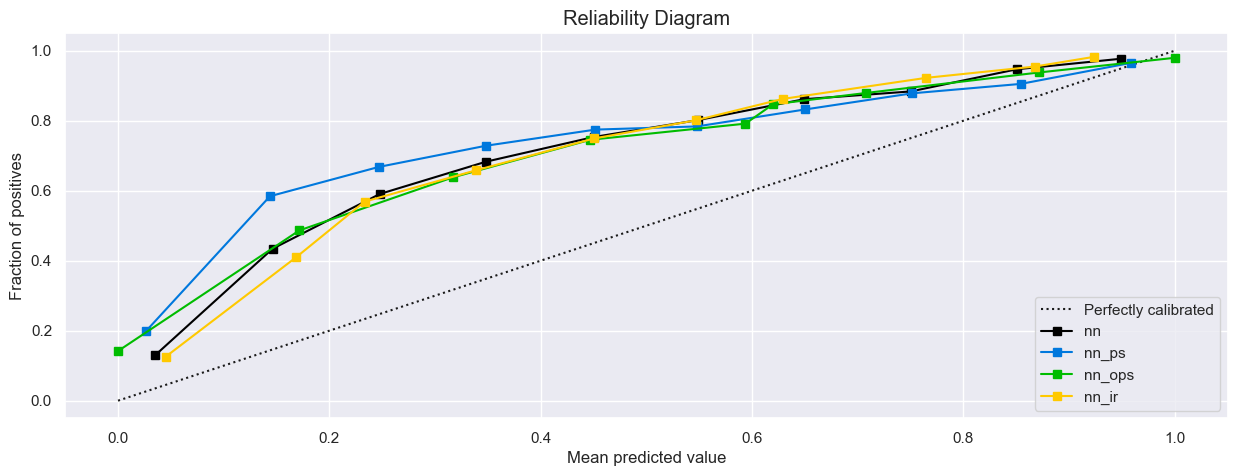

In [12]:
skplt.metrics.plot_calibration_curve(y_test, 
                                     probas_list=list(models_preds.values()), 
                                     clf_names=list(models_preds.keys()), 
                                     n_bins=10,
                                     title="Reliability Diagram")
plt.show()

Plot probability distribution of every nn model

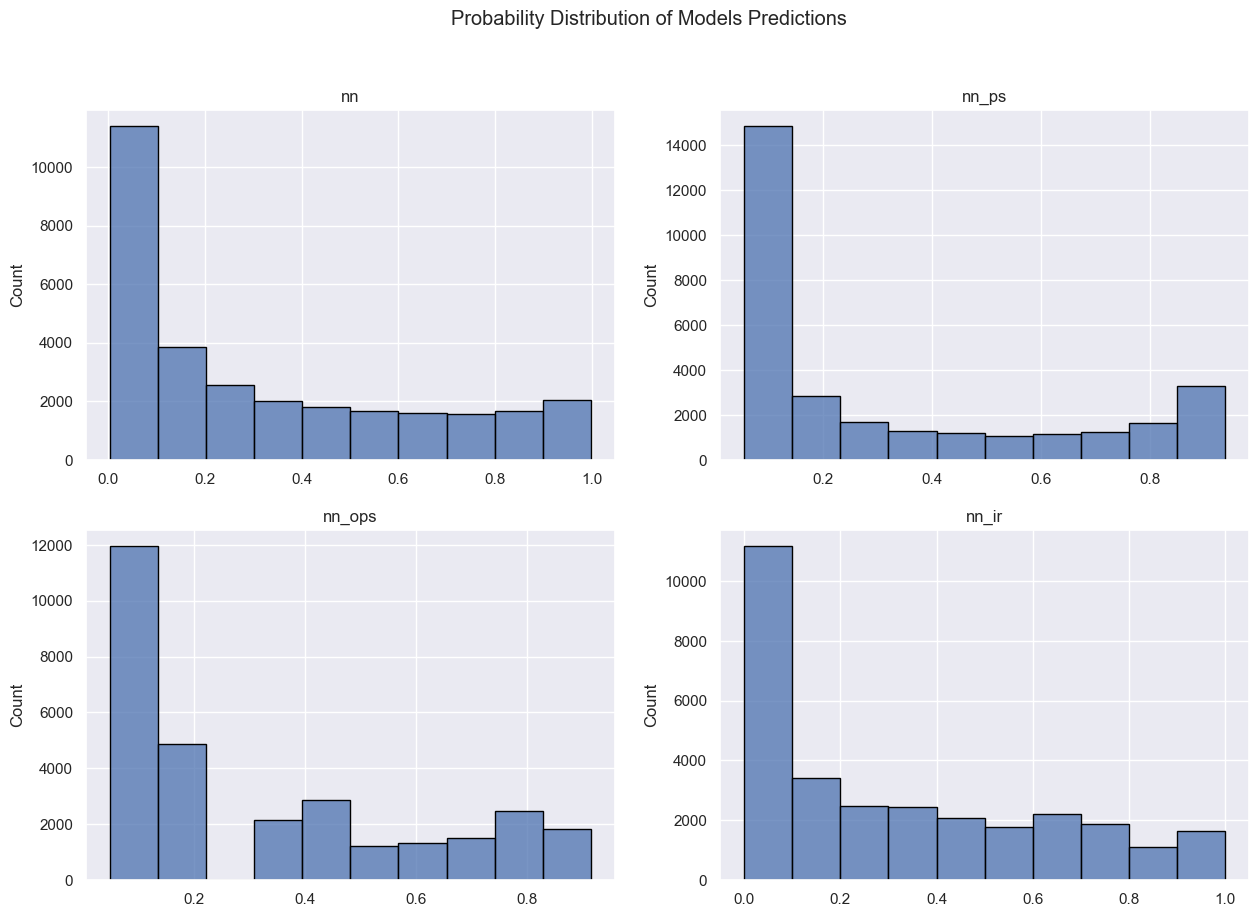

In [13]:
# plot seperate histogram of models predictions on the test set
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for i, model_name in enumerate(models_preds.keys()):
    sns.histplot(models_preds[model_name], ax=axes[i], bins=10, edgecolor="black")
    axes[i].set_title(model_name)
plt.suptitle("Probability Distribution of Models Predictions")
plt.show()

plot model statistics on accuracy and calibration

In [14]:
# plot table of models statistics containing accuracy, f1-score, brier score ECE and MCE
stats = pd.DataFrame(columns=["accuracy", "f1-score", "brier score", "ECE", "MCE", "OCE"])

for model_name in models_preds.keys():
    # calculate the statistics
    acc = accuracy_score(y_test, np.round(models_preds[model_name]))
    f1 = f1_score(y_test, np.round(models_preds[model_name]))
    brier_score = brier_score_loss(y_test, models_preds[model_name])
    ece = expected_calibration_error(y_test, models_preds[model_name])
    mce = max_calibration_error(y_test, models_preds[model_name])
    oce = overconfidence_error(y_test, models_preds[model_name])

    # add the statistics to the table
    stats.loc[model_name] = [acc, f1, brier_score, ece, mce, oce]

# Print the table
table = tabulate(stats, headers='keys', tablefmt='github')
print(table)

|        |   accuracy |   f1-score |   brier score |      ECE |      MCE |       OCE |
|--------|------------|------------|---------------|----------|----------|-----------|
| nn     |   0.72581  |   0.650338 |      0.186645 | 0.179783 | 0.340889 | 0.0437987 |
| nn_ps  |   0.721273 |   0.640867 |      0.195056 | 0.180796 | 0.393493 | 0.0498261 |
| nn_ops |   0.721273 |   0.640867 |      0.188959 | 0.181914 | 0.314871 | 0.0423007 |
| nn_ir  |   0.726008 |   0.650739 |      0.184955 | 0.179471 | 0.335305 | 0.0424695 |
